# Part 1 

## CCX gate, aka Toffoli

Caviat, I was doing it in Qiskit and I just stuck with it, they are following little endian convention.

https://qiskit.org/documentation/stubs/qiskit.circuit.library.CCXGate.html

In [59]:
from qiskit import Aer, transpile
from qiskit import QuantumCircuit, transpile

from qiskit.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit.visualization import array_to_latex

import qiskit.quantum_info as qi
import numpy as np

# Example usage:
# Create two circuits (circuit1 and circuit2) and then check if they are equivalent:
# are_circuits_equivalent(circuit1, circuit2, num_qubits)

def are_circuits_equivalent(circuit1, circuit2, num_qubits):
    # Transpile circuits to ensure that they are expressed in terms of the same gate set
    circuit1 = transpile(circuit1, basis_gates=['u1','u2','u3','cx'])
    circuit2 = transpile(circuit2, basis_gates=['u1','u2','u3','cx'])

    # Method 1: Compare Unitary Matrices
    unitary1 = qi.Operator(circuit1)
    unitary2 = qi.Operator(circuit2)
    
    # Check if unitaries are equal (up to a global phase)
    if unitary1.equiv(unitary2):
        print("Method 1: Circuits are equivalent")
    else:
        print("Method 1: Circuits are NOT equivalent")
    
    # Method 2: Compare Outputs on All Basis States
    simulator = Aer.get_backend('statevector_simulator')
    equivalent = True
    
    for i in range(2**num_qubits):
        # Create a binary string of the current i, padded with zeros to match num_qubits
        input_state = format(i, f'0{num_qubits}b')
        
        # Initialize circuits with the current input state
        test_circuit1 = QuantumCircuit(num_qubits)
        test_circuit2 = QuantumCircuit(num_qubits)
        
        for j, bit in enumerate(input_state):
            if bit == '1':
                test_circuit1.x(j)
                test_circuit2.x(j)
        
        # Append the circuits to be checked
        test_circuit1 = test_circuit1.compose(circuit1)
        test_circuit2 = test_circuit2.compose(circuit2)
        
        # Get final statevectors
        result1 = simulator.run(test_circuit1).result().get_statevector()
        result2 = simulator.run(test_circuit2).result().get_statevector()
        
        # Check if the output states are equal (up to a global phase)
#         print(np.angle(result1), np.angle(result2))
        if not np.allclose(np.angle(result1), np.angle(result2), atol=1e-8):
            equivalent = False
            break
    
    if equivalent:
        print("Method 2: Circuits are equivalent")
    else:
        print("Method 2: Circuits are NOT equivalent")


def custom_toffoli(circuit, control_qubit1, control_qubit2, target_qubit):
    """
    Implements a Toffoli gate using qubits control_qubit1, control_qubit2 as controls, 
    and target_qubit as the target. Utilizes CNOT and U gates.
    """
    
    # Apply Hadamard to the target qubit
    circuit.h(target_qubit)
    
    # Apply controlled rotations
    circuit.cx(control_qubit2, target_qubit)
    circuit.tdg(target_qubit)
    circuit.cx(control_qubit1, target_qubit)
    circuit.t(target_qubit)
    circuit.cx(control_qubit2, target_qubit)
    circuit.tdg(target_qubit)
    circuit.cx(control_qubit1, target_qubit)
    
    # Apply additional gates
    circuit.t(control_qubit2)
    circuit.t(target_qubit)
    circuit.h(target_qubit)
    circuit.cx(control_qubit1, control_qubit2)
    circuit.t(control_qubit1)
    circuit.tdg(control_qubit2)
    circuit.cx(control_qubit1, control_qubit2)


CUSTOM TOFFOLI


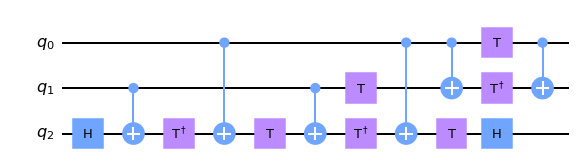

In [60]:
qc = QuantumCircuit(3)
custom_toffoli(qc, 0, 1, 2)
print('CUSTOM TOFFOLI')
qc.draw('mpl')

QISKIT TOFFOLI


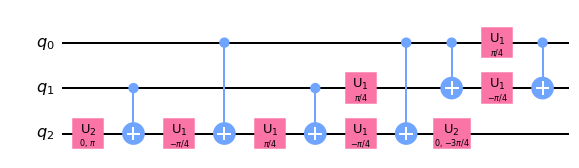

In [61]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc_decomposed = transpile(qc, basis_gates=['u1','u2','u3','cx'])
print("QISKIT TOFFOLI")
qc_decomposed.draw('mpl')

In [62]:
are_circuits_equivalent(qc, qc_decomposed, 3)

Method 1: Circuits are equivalent
Method 2: Circuits are equivalent


In [63]:
qc_custom = QuantumCircuit(3)
custom_toffoli(qc_custom, 0, 1, 2) 
unitary_custom = qi.Operator(qc_custom).data
print('CUSTOM TOFFOLI MATRIX')
array_to_latex(unitary_custom)

CUSTOM TOFFOLI MATRIX


<IPython.core.display.Latex object>

In [64]:
qc_built_in = QuantumCircuit(3)
qc_built_in.ccx(0, 1, 2)
unitary_built_in = qi.Operator(qc_built_in).data
print('QISKIT TOFFOLI MATRIX')
array_to_latex(unitary_built_in)

QISKIT TOFFOLI MATRIX


<IPython.core.display.Latex object>

### Part 2 MCX

In [65]:
qc = QuantumCircuit(3)
custom_toffoli(qc, 0, 1, 2)
toffoli_gate = qc.to_gate(label = 'Toff')


In [66]:
from qiskit import QuantumRegister

def custom_mcx_circuit(n):
    num_controls = n
    num_anc = num_controls - 2
    cntr = QuantumRegister(num_controls, 'ctrl')
    ancl = QuantumRegister(num_anc, 'ancl')
    targ = QuantumRegister(1, 'targ')
    qc = QuantumCircuit(cntr, ancl, targ)
    a = [x for x in range(n)]
    b = [x + n for x in range(n - 2)]
    c = n * 2 - 2
    return qc, a, b, c

def custom_mcx(qc, control_qubits, auxiliary_qubits, target_qubit):
    num_controls = len(control_qubits)
    if num_controls == 2:
        qc.append(toffoli_gate, [control_qubits[0], control_qubits[1], target_qubit])
        return
    custom_mcx(qc, control_qubits[:-1], auxiliary_qubits[:-1], auxiliary_qubits[-1])
    qc.append(toffoli_gate, [control_qubits[-1], auxiliary_qubits[-1], target_qubit])
    custom_mcx(qc, control_qubits[:-1], auxiliary_qubits[:-1], auxiliary_qubits[-1])
    

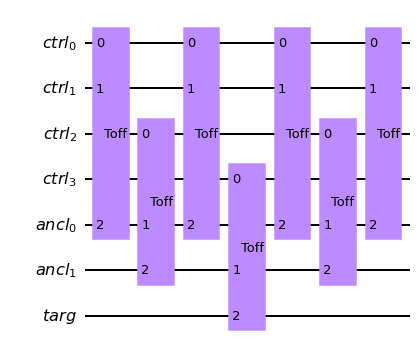

In [67]:
num_controls = 4
qc, control_qubits, auxiliary_qubits, target_qubit = custom_mcx_circuit(num_controls)
custom_mcx(qc, control_qubits, auxiliary_qubits, target_qubit)
qc.draw('mpl')

In [68]:
qc_built_in = QuantumCircuit(num_controls + len(auxiliary_qubits) + 1)  
qc_built_in.mcx(control_qubits, target_qubit, auxiliary_qubits, mode='basic')  # Using basic mode for simplicity
qc_built_in = transpile(qc_built_in, basis_gates=['cx','u3'])  # Transpile to CNOT and U3 gates

qc_custom = QuantumCircuit(num_controls + len(auxiliary_qubits) + 1)  # +1 for the target qubit, +1 for auxiliary qubit
custom_mcx(qc_custom, control_qubits, auxiliary_qubits, target_qubit)

unitary_built_in = qi.Operator(qc_built_in).data
unitary_custom = qi.Operator(qc_custom).data

if qi.Operator(qc_built_in).equiv(qc_custom):
    print("The built-in and custom Toffoli gates are equivalent up to a global phase.")
else:
    print("The built-in and custom Toffoli gates are NOT equivalent.")
    
found_diff = False
for i in range(len(unitary_built_in)):
    for j in range(len(unitary_built_in)):
        if abs(unitary_built_in[i][j] - unitary_custom[i][j]) > 1e-8:
            print(i, j, unitary_built_in[i][j], unitary_custom[i][j],
                 np.round(abs(unitary_built_in[i][j] - unitary_custom[i][j])))
            found_diff = True

if (found_diff == False):
    print()
    print("No Difference found in the matrix forms")
else:
    print("Diff above")

The built-in and custom Toffoli gates are equivalent up to a global phase.

No Difference found in the matrix forms


# Part 1.1 If we really need the matrix in nice print, reverse operators

In [69]:
qc_custom = QuantumCircuit(3)
custom_toffoli(qc_custom, 2, 1, 0) 
unitary_custom = qi.Operator(qc_custom).data
print('CUSTOM TOFFOLI MATRIX')
array_to_latex(unitary_custom)

CUSTOM TOFFOLI MATRIX


<IPython.core.display.Latex object>